In [1]:
import pandas as pd
import akshare as ak

# 800自由现金流，季度更新
# https://www.csindex.com.cn/#/indices/family/detail?indexCode=932368
stocks = [
'000039',
'000426',
'000513',
'000568',
'000651',
'000708',
'000792',
'000807',
'000858',
'000933',
'002001',
'002056',
'002120',
'002352',
'002532',
'002714',
'300002',
'300073',
'300498',
'300724',
'300803',
'600066',
'600096',
'600219',
'600258',
'600295',
'600312',
'600352',
'600380',
'600482',
'600585',
'600873',
'600938',
'600968',
'601156',
'601168',
'601212',
'601225',
'601231',
'601600',
'601877',
'601880',
'601919',
'603129',
'603233',
'603816',
'603833',
'603885',
'603939',
'603993'
]
# 一次性获取全市场 A 股实时行情
spot_df = ak.stock_zh_a_spot_em()

/home/jovyan/data/.venv/lib/python3.11/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  0%|          | 0/57 [00:00<?, ?it/s]

In [2]:
# 只看我们关心的列
spot_df = spot_df[["代码", "名称", "流通市值"]]

# 过滤出你的股票
my_df = spot_df[spot_df["代码"].isin(stocks)]

In [3]:
def weekly_return(code):
    try:
        df = ak.stock_zh_a_hist(symbol=code, period="weekly", adjust="hfq")
        if len(df) >= 2:
            last_week_close = df.iloc[-2]["收盘"]
            this_week_close = df.iloc[-1]["收盘"]
            return round((this_week_close / last_week_close - 1) * 100, 2)
    except Exception as e:
        print(f"{code} 获取失败: {e}")
    return None

# 添加周涨幅
my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)

/tmp/ipykernel_19706/1229572994.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)


In [4]:
my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)

# 综合得分（简单相加，也可以加权）
my_df["因子总分"] = my_df["市值_score"] + my_df["周涨幅_score"]

# 排序看前10个
result = my_df.sort_values("因子总分", ascending=False).head(10)
result

/tmp/ipykernel_19706/2716460985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,代码,名称,流通市值,周涨幅(%),市值_score,周涨幅_score,因子总分
2822,600380,健康元,2.361824e+10,0.29,5,5,10
4930,603233,大参林,1.942875e+10,-1.13,5,5,10
4101,002120,韵达股份,2.426637e+10,-0.50,5,5,10
2363,000039,中集集团,1.887154e+10,0.42,5,5,10
2426,600312,平高电气,2.203640e+10,0.42,5,5,10
5104,603939,益丰药房,2.921389e+10,-1.65,4,5,9
4811,300002,神州泰岳,2.613494e+10,-1.12,4,5,9
3213,600873,梅花生物,3.143773e+10,0.08,4,5,9
1035,600295,鄂尔多斯,2.046697e+10,1.53,5,3,8
2676,603885,吉祥航空,2.782423e+10,0.44,4,4,8


In [5]:
import empyrical
import alphalens as al

In [12]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import datetime as dt
import alphalens as al

# 股票池
codes = ['000039','000426','000513','000568','000651','000708','000792','000807',
         '000858','000933','002001','002056','002120','002352','002532','002714',
         '300002','300073','300498','300724','300803','600066','600096','600219',
         '600258','600295','600312','600352','600380','600482','600585','600873',
         '600938','600968','601156','601168','601212','601225','601231','601600',
         '601877','601880','601919','603129','603233','603816','603833','603885',
         '603939','603993']

start = '2023-08-19'
end   = '2025-08-19'

tickers = codes

# ---------- 1. 拉后复权周 K ----------
def weekly_hfq(code):
    df = ak.stock_zh_a_hist(symbol=code, period="weekly",
                            start_date=start.replace('-', ''),
                            end_date=end.replace('-', ''),
                            adjust="hfq")
    # 统一列名为小写英文
    df = df.rename(columns=str.lower)          # Date -> date
    df = df.rename(columns={'日期': 'date',   # 中文兜底
                            '收盘': 'close'})
    df = df[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['code'] = code
    return df[['date', 'code', 'close']]

prices = []
for t in tqdm(tickers):
    prices.append(weekly_hfq(t))
prices = pd.concat(prices, ignore_index=True)

# 构造价格透视表：行=date, 列=code
prices_pivot = prices.pivot(index='date', columns='code', values='close')

100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


In [13]:
prices.to_parquet("data.parquet", engine="pyarrow", index=False)

code        000039  000426  000513  000568  000651  000708  000792  000807  \
date                                                                         
2020-08-28    0.91    2.61    4.37    9.90    2.82    3.58   -4.35    1.67   
2020-09-04    0.93    2.78    4.24   10.99    2.90    3.54   -5.66    1.60   
2020-09-11    0.91    2.64    3.94   10.22    2.89    3.46   -5.66    1.60   
2020-09-18    0.96    2.69    4.11   10.26    2.95    3.59   -5.66    1.66   
2020-09-25    0.91    2.45    4.09    9.94    2.88    3.31   -5.66    1.52   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-08-01    0.91    3.84    2.69    3.61    1.80    1.54    2.52    1.86   
2025-08-08    0.91    4.05    2.56    3.77    1.84    1.54    2.59    1.92   
2025-08-15    0.91    4.36    2.56    3.66    1.87    1.55    2.69    2.09   
2025-08-22    0.91    4.25    2.73    3.80    1.82    1.59    2.71    2.06   
2025-08-29    0.92    4.41    2.75    4.08    1.88    1.63    2.

,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.370382,-0.499691,-0.884324,0.177754,934,20.304348
2,-0.901124,-0.236978,-0.517449,0.120770,922,20.043478
3,-0.440780,0.130837,-0.196867,0.110282,916,19.913043
4,-0.230281,0.681542,0.190304,0.177573,910,19.782609
5,0.266648,6.158341,1.427234,1.283055,918,19.956522


Returns Analysis


,12D
Ann. alpha,-0.273
beta,0.438
Mean Period Wise Return Top Quantile (bps),149.780
Mean Period Wise Return Bottom Quantile (bps),342.810
Mean Period Wise Spread (bps),-193.031


<Figure size 640x480 with 0 Axes>

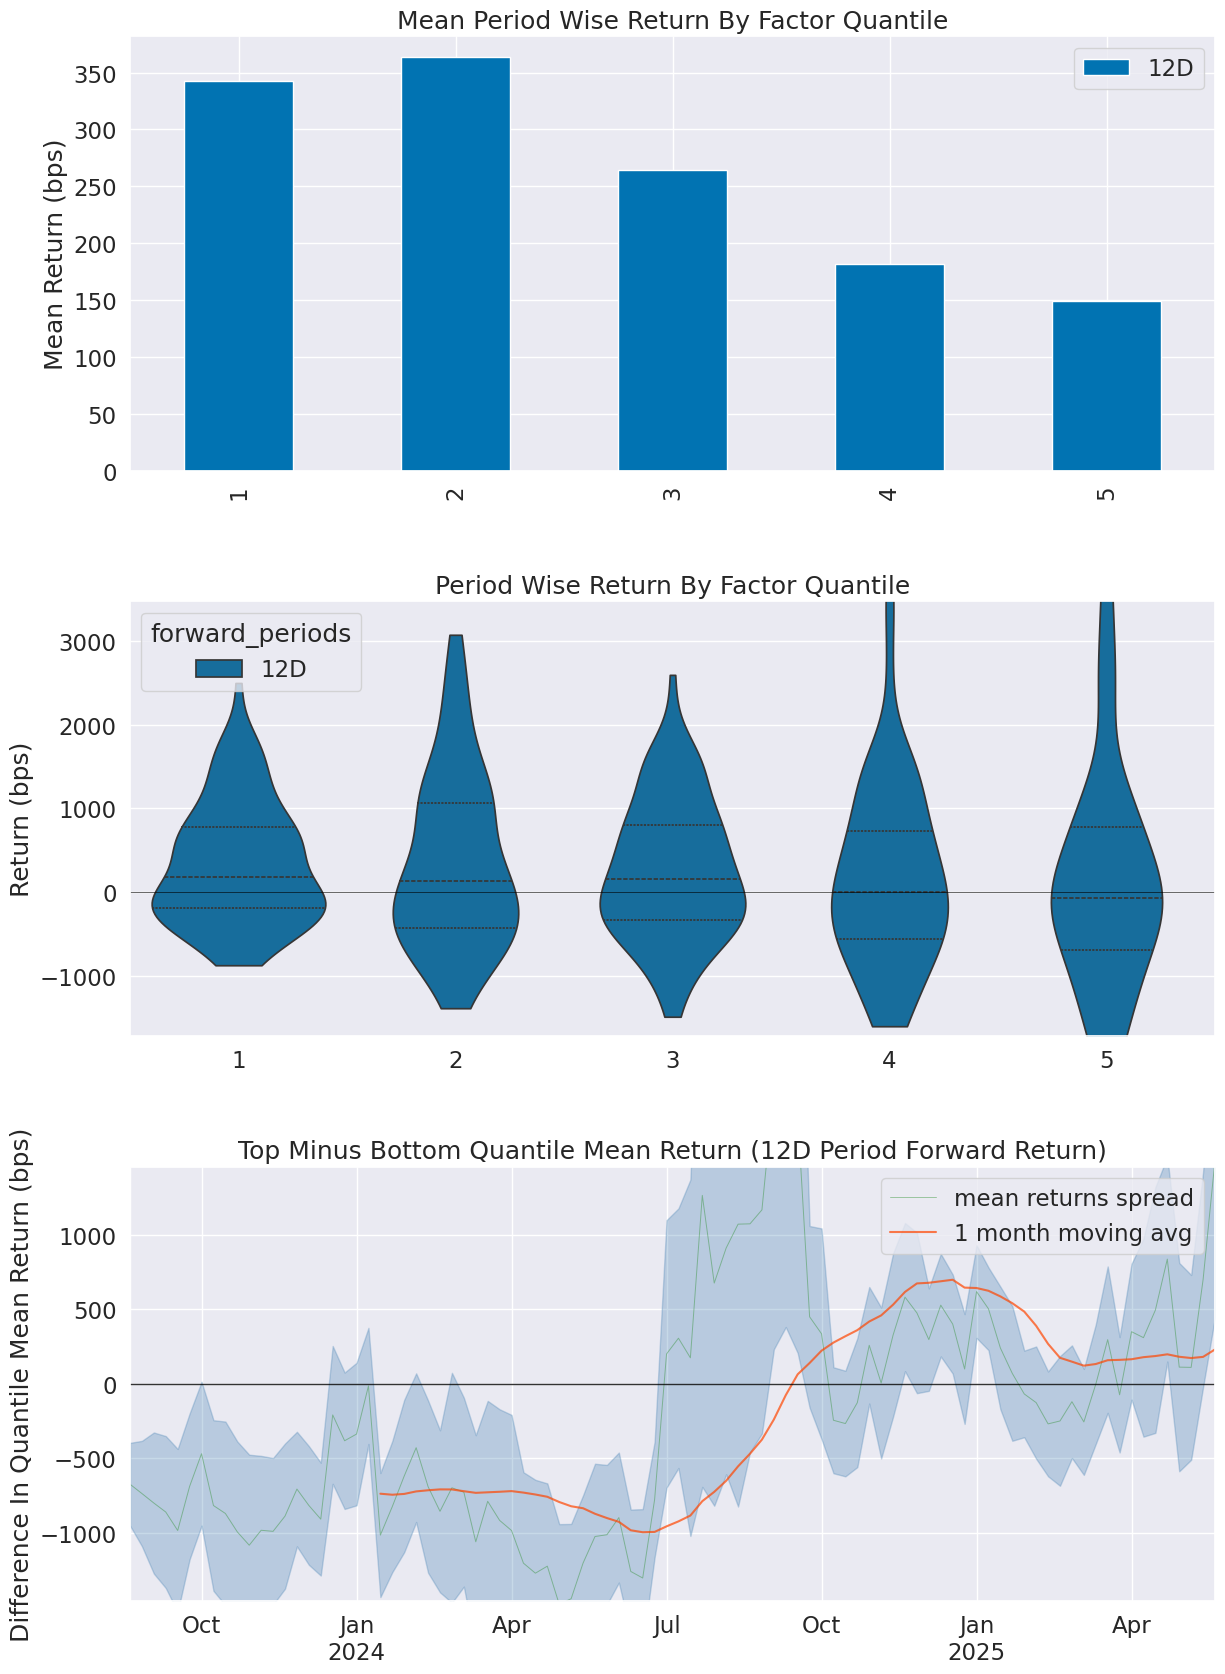

Information Analysis


,12D
IC Mean,-0.147
IC Std.,0.133
Risk-Adjusted IC,-1.107
t-stat(IC),-10.621
p-value(IC),0.000
IC Skew,0.401
IC Kurtosis,-0.422


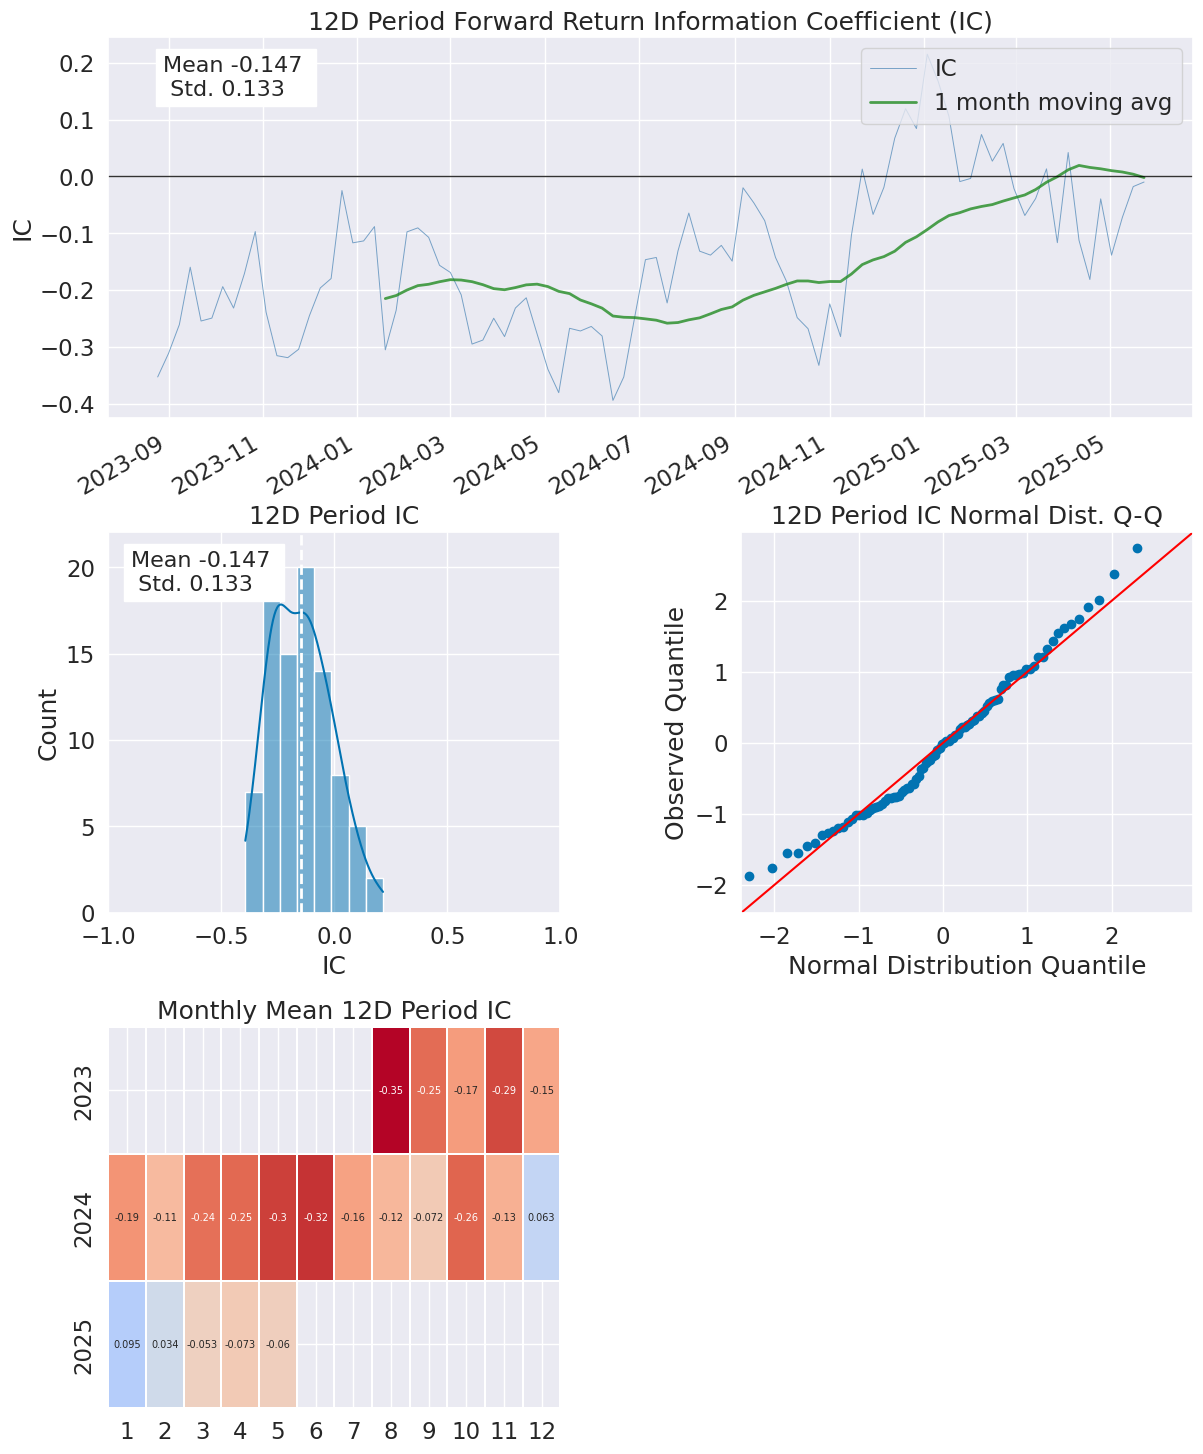

Turnover Analysis


,12D
Quantile 1 Mean Turnover,0.104
Quantile 2 Mean Turnover,0.310
Quantile 3 Mean Turnover,0.384
Quantile 4 Mean Turnover,0.314
Quantile 5 Mean Turnover,0.128


,12D
Mean Factor Rank Autocorrelation,0.963


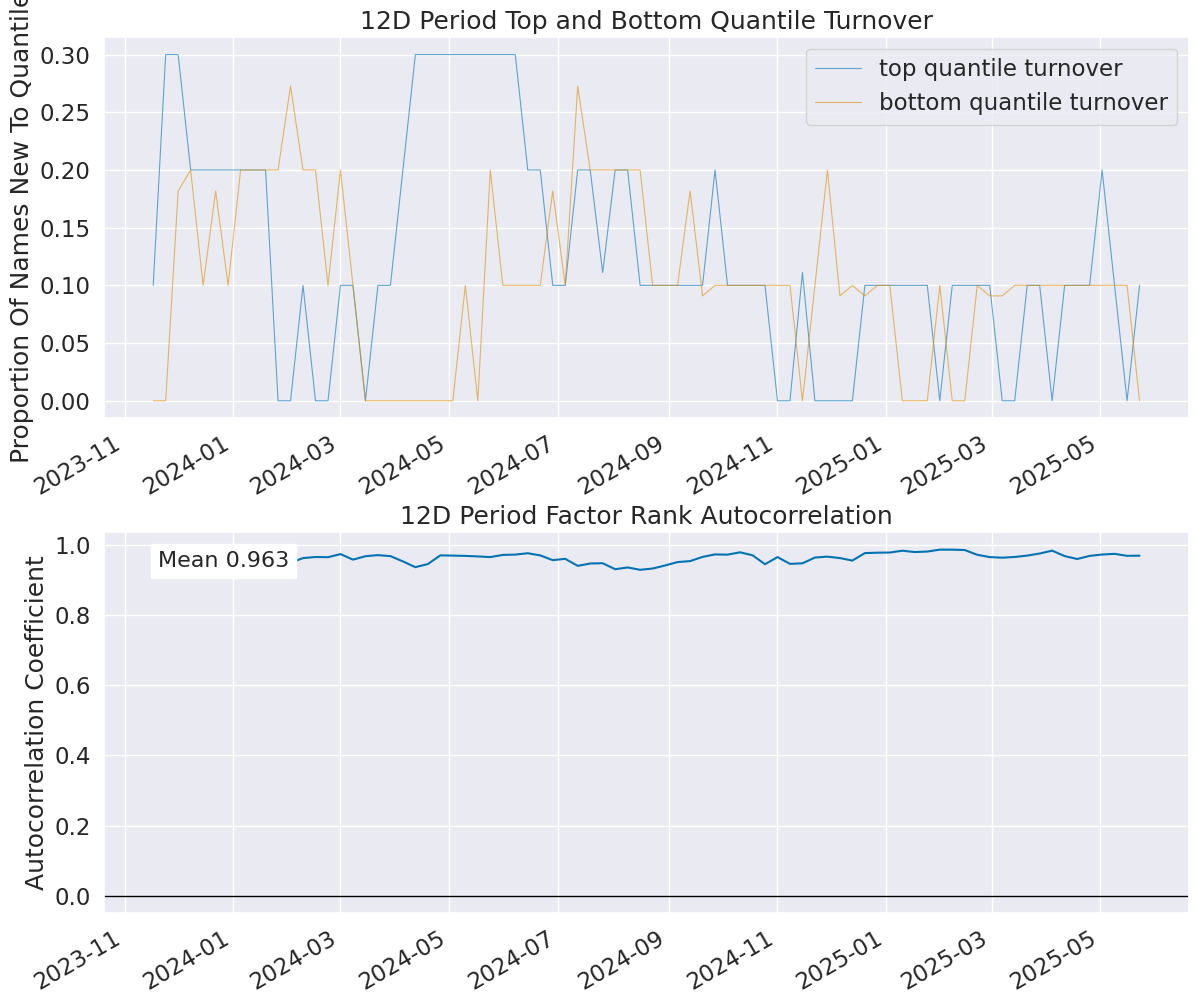

In [25]:
import pandas as pd
import numpy as np
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings
warnings.filterwarnings('ignore')

# 数据预处理
prices_df = pd.read_parquet("data.parquet", engine="pyarrow")
prices_df['date'] = pd.to_datetime(prices_df['date'])

# 转换为宽格式
price_pivot = prices_df.pivot(index='date', columns='code', values='close')
price_pivot.index = pd.to_datetime(price_pivot.index)
price_pivot = price_pivot.sort_index()
price_pivot = price_pivot.asfreq('W-FRI')

# 创建因子数据 - 使用当期价格作为因子
fatcors = pd.read_parquet("pb.parquet", engine="pyarrow")
factor_pivot = fatcors.pivot(index='date', columns='code', values='pb')  # 或者使用 price_pivot.shift(1) 作为滞后因子
factor_pivot_std = standardize_wide(factor_pivot)

def standardize_wide(df):
    def std_row(s):
        s_clip = s.clip(lower=s.quantile(0.01), upper=s.quantile(0.99))
        return (s_clip - s_clip.mean()) / (s_clip.std() or 1)
    return df.apply(std_row, axis=1)

factor_series = factor_pivot_std.stack()
factor_series.index.names = ['date', 'asset']
factor_series.name = 'factor'

print(f"数据时间范围: {price_pivot.index.min()} 到 {price_pivot.index.max()}")
print(f"股票数量: {len(price_pivot.columns)}")
print(f"交易周数: {len(price_pivot)}")

try:
    # 使用 alphalens 处理数据
    factor_data_clean = get_clean_factor_and_forward_returns(
        factor=factor_series,
        prices=price_pivot,
        periods=[12],  # 1周前瞻收益
        max_loss=0.80,
        quantiles=5
    )
    
    print("因子数据处理成功!")
    print(f"有效因子数据点: {len(factor_data_clean)}")
    
    # 创建完整的分析报告
    print("正在生成完整分析报告...")
    
    # 生成 full tear sheet
    create_full_tear_sheet(
        factor_data=factor_data_clean,
        long_short=False,
        group_neutral=False,
        by_group=False
    )
    
except Exception as e:
    print(f"生成报告时出错: {e}")
    import traceback
    traceback.print_exc()

In [23]:
print(factor_series_std.head())
print("nlevels:", factor_series_std.index.nlevels)  # 应为 2
print("names:", factor_series_std.index.names)      # 应为 ['date', 'asset']
print("name:", factor_series_std.name)

date        asset 
2020-08-28  000039    0.91
            000426    2.61
            000513    4.37
            000568    9.90
            000651    2.82
Name: factor, dtype: float64
nlevels: 2
names: ['date', 'asset']
name: factor
